# Analyze the trained model

## Set up

In [63]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Load the trained model

In [64]:
import torch
import yaml
from model import PathIntRNN
from model_lightning import PathIntRNNLightning
import glob

run_id = "20250804_181740"

run_dir = f"logs/checkpoints/{run_id}"
config_path = f"{run_dir}/config_{run_id}.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


checkpoint_files = glob.glob(f"{run_dir}/best-model-*.ckpt")
print(f"Loading Lightning checkpoint from: {checkpoint_files[0]}")
rnn_lightning = PathIntRNNLightning.load_from_checkpoint(
    checkpoint_files[0],
    model=PathIntRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["output_size"],
        alpha=config["alpha"],
    ),
    lr=config["learning_rate"],
)

model = rnn_lightning.model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"Loaded model from run: {run_id}")
print(f"Model config: {config_path}")
print(f"Device: {device}")

Loading Lightning checkpoint from: logs/checkpoints/20250804_181740/best-model-epoch=483-val_loss=2.036.ckpt
Loaded model from run: 20250804_181740
Model config: logs/checkpoints/20250804_181740/config_20250804_181740.yaml
Device: cuda


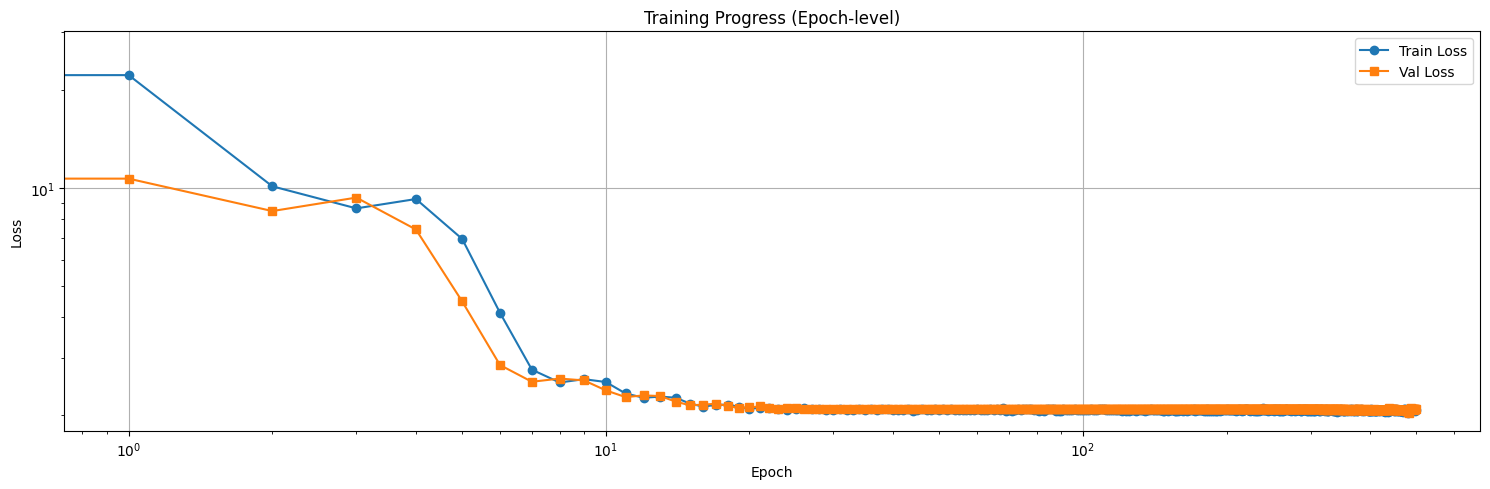

Initial train loss:  10.3966
Final train loss:  2.0733
Initial val loss:  26.5815
Final val loss:  2.0858


In [65]:
import json
import matplotlib.pyplot as plt

with open(f"{run_dir}/training_losses.json", "r") as f:
    loss_data = json.load(f)

plt.figure(figsize=(15, 5))

plt.plot(
    loss_data["epochs"][:-1], loss_data["train_losses_epoch"], "o-", label="Train Loss"
)
plt.plot(
    loss_data["epochs"][:-1], loss_data["val_losses_epoch"][:-1], "s-", label="Val Loss"
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.yscale("log")
plt.xscale("log")

plt.title("Training Progress (Epoch-level)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Initial train loss: ", f"{loss_data['train_losses_epoch'][0]:.4f}")
print("Final train loss: ", f"{loss_data['train_losses_epoch'][-1]:.4f}")

print("Initial val loss: ", f"{loss_data['val_losses_epoch'][0]:.4f}")
print("Final val loss: ", f"{loss_data['val_losses_epoch'][-1]:.4f}")

## Load evaluation datamodule

In [66]:
from datamodule import PathIntegrationDataModule


num_trajectories = 500
batch_size = 1

eval_datamodule = PathIntegrationDataModule(
    num_trajectories=num_trajectories,
    batch_size=batch_size,
    num_workers=1,
    train_val_split=0.0,
    start_time=config["start_time"],
    end_time=config["end_time"],
    num_time_steps=config["num_time_steps"],
    arena_L=config["arena_L"],
    mu_speed=config["mu_speed"],
    sigma_speed=config["sigma_speed"],
    tau_vel=config["tau_vel"],
)

eval_datamodule.setup()

eval_loader = eval_datamodule.val_dataloader()

print(f"Number of validation batches: {len(eval_loader)}")
print(f"Validation dataset size: {len(eval_datamodule.val_dataset)}")

Number of validation batches: 500
Validation dataset size: 500


In [67]:
import torch

model.eval()

all_hidden_states = []
all_outputs = []
all_inputs = []
all_targets = []

num_batches = 4  # or however many you want

with torch.no_grad():
    for i, (inputs, targets) in enumerate(eval_loader):
        if i >= num_batches:
            break

        inputs = inputs.to(device)
        targets = targets.to(device)

        hidden_states, outputs = model(inputs=inputs, pos_0=targets[:, 0, :])

        all_hidden_states.append(hidden_states)
        all_outputs.append(outputs)
        all_inputs.append(inputs)
        all_targets.append(targets)

# Concatenate all batches
hidden_states = torch.cat(all_hidden_states, dim=0)
outputs = torch.cat(all_outputs, dim=0)
inputs = torch.cat(all_inputs, dim=0)
targets = torch.cat(all_targets, dim=0)

print(hidden_states.shape)
print(outputs.shape)

torch.Size([4, 1000, 400])
torch.Size([4, 1000, 2])


## Visualize PCA of hidden states

In [68]:
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

# ===== TRAINED MODEL (what you already have) =====
model.eval()

trained_hidden_states = []
trained_outputs = []
all_inputs = []
all_targets = []

num_batches = 4

with torch.no_grad():
    for i, (inputs, targets) in enumerate(eval_loader):
        if i >= num_batches:
            break

        inputs = inputs.to(device)
        targets = targets.to(device)

        hidden_states, outputs = model(inputs=inputs, pos_0=targets[:, 0, :])

        trained_hidden_states.append(hidden_states)
        trained_outputs.append(outputs)
        all_inputs.append(inputs)
        all_targets.append(targets)

# Concatenate trained model results
trained_hidden_states = torch.cat(trained_hidden_states, dim=0)
inputs = torch.cat(all_inputs, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Trained hidden states shape: {trained_hidden_states.shape}")

# ===== UNTRAINED MODEL =====
# Create a fresh untrained model with same architecture
untrained_model = PathIntRNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    alpha=config["alpha"],
)
untrained_model.to(device)
untrained_model.eval()

untrained_hidden_states = []

with torch.no_grad():
    # Use the SAME inputs as the trained model
    for i in range(inputs.shape[0]):
        # Process one trajectory at a time
        single_input = inputs[i : i + 1]  # Keep batch dimension
        single_target = targets[i : i + 1]

        hidden_states, _ = untrained_model(
            inputs=single_input, pos_0=single_target[:, 0, :]
        )
        untrained_hidden_states.append(hidden_states)

untrained_hidden_states = torch.cat(untrained_hidden_states, dim=0)

print(f"Untrained hidden states shape: {untrained_hidden_states.shape}")

# ===== PCA ANALYSIS =====
# Reshape for PCA
trained_data = trained_hidden_states.reshape(-1, trained_hidden_states.shape[-1]).cpu()
untrained_data = untrained_hidden_states.reshape(
    -1, untrained_hidden_states.shape[-1]
).cpu()

# Fit separate PCAs - each optimized for its own data
pca_trained = PCA(n_components=3)
pca_untrained = PCA(n_components=3)

trained_pca = pca_trained.fit_transform(trained_data)
untrained_pca = pca_untrained.fit_transform(untrained_data)

print(
    f"Trained model variance explained: {pca_trained.explained_variance_ratio_.sum() * 100:.2f}%"
)
print(
    f"Untrained model variance explained: {pca_untrained.explained_variance_ratio_.sum() * 100:.2f}%"
)

Trained hidden states shape: torch.Size([4, 1000, 400])
Untrained hidden states shape: torch.Size([4, 1000, 400])
Trained model variance explained: 99.55%
Untrained model variance explained: 81.92%


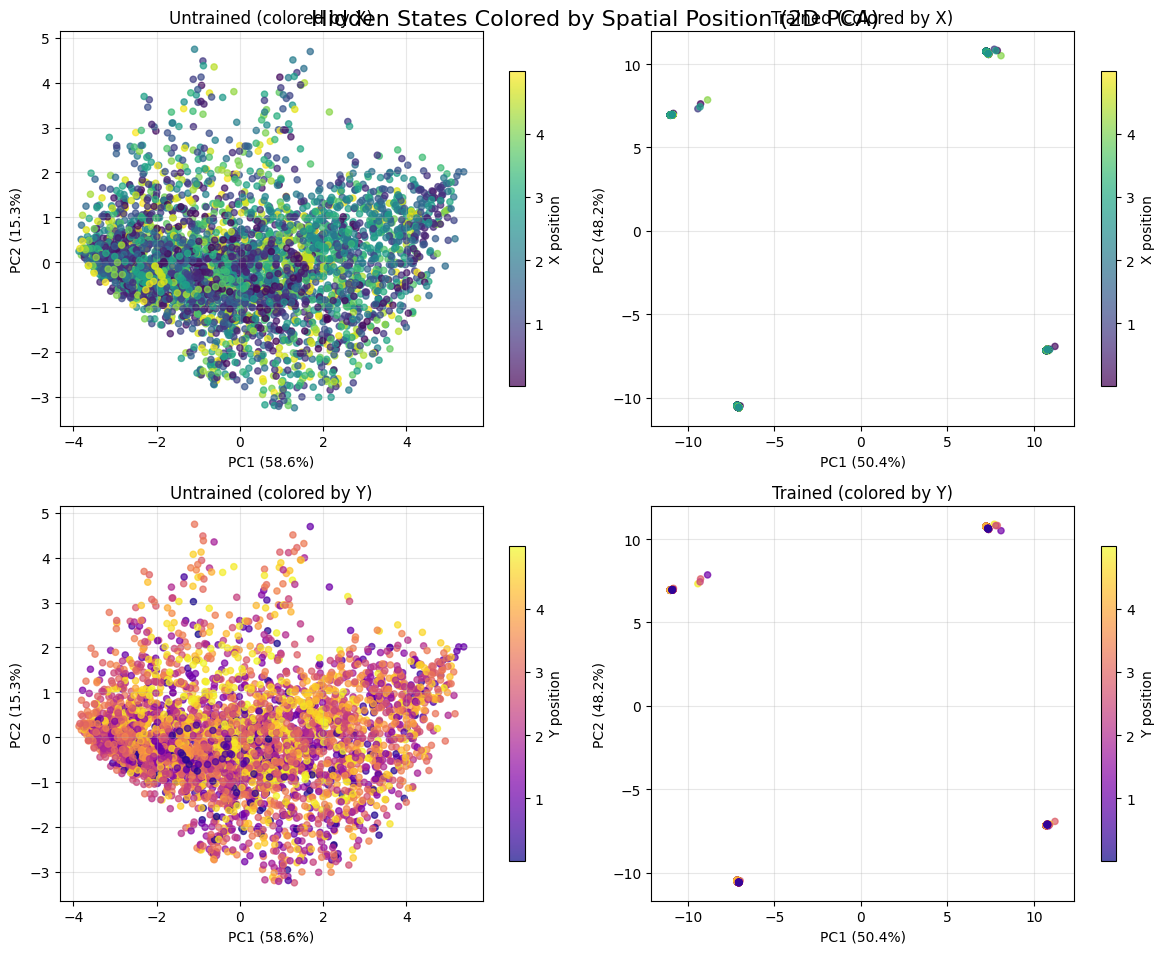

PC1+PC2 variance explained:
  Untrained: 73.9%
  Trained: 98.5%

Coordinate ranges:
  X: [0.00, 5.00]
  Y: [0.01, 5.00]


In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Extract just PC1 and PC2 for 2D plots
untrained_2d = untrained_pca[:, :2]
trained_2d = trained_pca[:, :2]

# Row 1: Color by X coordinate
# Untrained - X
scatter1 = axes[0, 0].scatter(
    untrained_2d[:, 0], untrained_2d[:, 1], c=x_coords, cmap="viridis", s=20, alpha=0.7
)
axes[0, 0].set_title("Untrained (colored by X)")
axes[0, 0].set_xlabel(f"PC1 ({pca_untrained.explained_variance_ratio_[0]*100:.1f}%)")
axes[0, 0].set_ylabel(f"PC2 ({pca_untrained.explained_variance_ratio_[1]*100:.1f}%)")
axes[0, 0].grid(True, alpha=0.3)

# Trained - X
scatter2 = axes[0, 1].scatter(
    trained_2d[:, 0], trained_2d[:, 1], c=x_coords, cmap="viridis", s=20, alpha=0.7
)
axes[0, 1].set_title("Trained (colored by X)")
axes[0, 1].set_xlabel(f"PC1 ({pca_trained.explained_variance_ratio_[0]*100:.1f}%)")
axes[0, 1].set_ylabel(f"PC2 ({pca_trained.explained_variance_ratio_[1]*100:.1f}%)")
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Color by Y coordinate
# Untrained - Y
scatter3 = axes[1, 0].scatter(
    untrained_2d[:, 0], untrained_2d[:, 1], c=y_coords, cmap="plasma", s=20, alpha=0.7
)
axes[1, 0].set_title("Untrained (colored by Y)")
axes[1, 0].set_xlabel(f"PC1 ({pca_untrained.explained_variance_ratio_[0]*100:.1f}%)")
axes[1, 0].set_ylabel(f"PC2 ({pca_untrained.explained_variance_ratio_[1]*100:.1f}%)")
axes[1, 0].grid(True, alpha=0.3)

# Trained - Y
scatter4 = axes[1, 1].scatter(
    trained_2d[:, 0], trained_2d[:, 1], c=y_coords, cmap="plasma", s=20, alpha=0.7
)
axes[1, 1].set_title("Trained (colored by Y)")
axes[1, 1].set_xlabel(f"PC1 ({pca_trained.explained_variance_ratio_[0]*100:.1f}%)")
axes[1, 1].set_ylabel(f"PC2 ({pca_trained.explained_variance_ratio_[1]*100:.1f}%)")
axes[1, 1].grid(True, alpha=0.3)

# Add colorbars
# X coordinate colorbars (top row)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0], shrink=0.8)
cbar1.set_label("X position")
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1], shrink=0.8)
cbar2.set_label("X position")

# Y coordinate colorbars (bottom row)
cbar3 = plt.colorbar(scatter3, ax=axes[1, 0], shrink=0.8)
cbar3.set_label("Y position")
cbar4 = plt.colorbar(scatter4, ax=axes[1, 1], shrink=0.8)
cbar4.set_label("Y position")

# Overall title and layout
fig.suptitle("Hidden States Colored by Spatial Position (2D PCA)", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"PC1+PC2 variance explained:")
print(f"  Untrained: {(pca_untrained.explained_variance_ratio_[:2].sum())*100:.1f}%")
print(f"  Trained: {(pca_trained.explained_variance_ratio_[:2].sum())*100:.1f}%")

print(f"\nCoordinate ranges:")
print(f"  X: [{x_coords.min():.2f}, {x_coords.max():.2f}]")
print(f"  Y: [{y_coords.min():.2f}, {y_coords.max():.2f}]")

## Create animation

In [85]:
# In analyze.ipynb
from viz import create_trajectory_animation

# Create animation
video_path = create_trajectory_animation(
    trained_model=model,
    untrained_model=untrained_model,
    eval_data=(inputs, targets),
    pca_trained=pca_trained,
    pca_untrained=pca_untrained,
    device=device,
    trajectory_idx=0,
    num_frames=200,
    fps=5,
    run_id=run_id,
)

print(f"Video saved at: {video_path}")

Creating trajectory animation for run: 20250804_181740
Trajectory data prepared: 1000 time steps
Animating first 200 steps
Speed range: 0.016 to 1.754
Creating animation...
Saving video as ./trajectory_analysis_run_20250804_181740.mp4...
Video saved as ./trajectory_analysis_run_20250804_181740.mp4

Trajectory Statistics:
Duration: 1000 time steps
Mean prediction error: 1.545
Final prediction error: 2.118
Speed range: 0.016 to 1.754
Video saved at: ./trajectory_analysis_run_20250804_181740.mp4
